In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v1", render_mode="human")

In [3]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 48)
        self.fc2 = nn.Linear(48, 24)
        self.fc3 = nn.Linear(24, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

policy_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
target_net = QNetwork(env.observation_space.shape[0], env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [4]:
num_episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
target_update_interval = 10

In [5]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(policy_net(torch.FloatTensor(state))).item()

In [6]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(max_size=10000)

In [7]:
optimizer = optim.Adam(policy_net.parameters())
rewards = []

for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, truncated, info = env.step(action)

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # env.render()

        if len(replay_buffer) > batch_size:
            experiences = replay_buffer.sample(batch_size)
            batch = list(zip(*experiences))
            states, actions, rewards_batch, next_states, dones = [torch.FloatTensor(x) for x in batch]
            actions = actions.long()

            q_values = policy_net(states)
            next_q_values = target_net(next_states)
            targets = rewards_batch + (1 - dones) * gamma * next_q_values.max(1)[0]

            optimizer.zero_grad()
            loss = nn.MSELoss()(q_values.gather(1, actions.unsqueeze(1)).squeeze(), targets.detach())
            loss.backward()
            optimizer.step()

    rewards.append(total_reward)

    if episode < 100:
        epsilon = 1.0 - (episode / 100)
    else:
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()

Episode 1, Total Reward: 12.0
Episode 2, Total Reward: 27.0
Episode 3, Total Reward: 17.0


C:\Users\TheKi\AppData\Local\Temp\ipykernel_13012\2190189330.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states, actions, rewards_batch, next_states, dones = [torch.FloatTensor(x) for x in batch]


Episode 4, Total Reward: 17.0
Episode 5, Total Reward: 24.0
Episode 6, Total Reward: 32.0
Episode 7, Total Reward: 19.0
Episode 8, Total Reward: 12.0
Episode 9, Total Reward: 17.0
Episode 10, Total Reward: 25.0
Episode 11, Total Reward: 18.0
Episode 12, Total Reward: 22.0
Episode 13, Total Reward: 15.0
Episode 14, Total Reward: 17.0
Episode 15, Total Reward: 16.0
Episode 16, Total Reward: 14.0
Episode 17, Total Reward: 12.0
Episode 18, Total Reward: 13.0
Episode 19, Total Reward: 12.0
Episode 20, Total Reward: 16.0
Episode 21, Total Reward: 17.0
Episode 22, Total Reward: 11.0
Episode 23, Total Reward: 11.0
Episode 24, Total Reward: 15.0
Episode 25, Total Reward: 14.0
Episode 26, Total Reward: 9.0
Episode 27, Total Reward: 18.0
Episode 28, Total Reward: 18.0
Episode 29, Total Reward: 12.0
Episode 30, Total Reward: 11.0
Episode 31, Total Reward: 12.0
Episode 32, Total Reward: 18.0
Episode 33, Total Reward: 12.0
Episode 34, Total Reward: 16.0
Episode 35, Total Reward: 9.0
Episode 36, Tota

KeyboardInterrupt: 

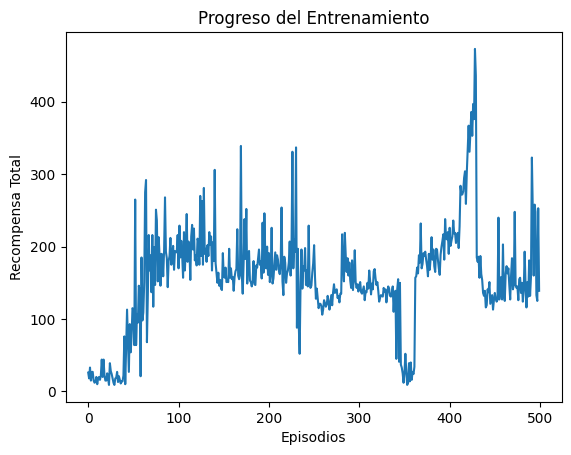

In [8]:
plt.plot(rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Total')
plt.title('Progreso del Entrenamiento')
plt.show()

In [9]:
def evaluate_agent(env, policy_net, num_eval_episodes=100):
    total_rewards = []

    for _ in range(num_eval_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state)).argmax().item()
            
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    avg_reward = sum(total_rewards) / num_eval_episodes
    return avg_reward

eval_env = gym.make("CartPole-v1")

average_reward = evaluate_agent(eval_env, policy_net)
print(f"Recompensa promedio en la evaluación: {average_reward}")

eval_env.close()


Recompensa promedio en la evaluación: 254.81


# Preguntas

### Proximal Policy Optimization
Es un algoritmo utilizado en el campo del aprendizaje por refuerzo profundo (Deep Reinforcement Learning) que ayuda a los agentes a mejorar sus decisiones mientras interactúan con un entorno. Este algoritmo es popular porque permite que el agente aprenda de manera más estable y eficiente, evitando cambios drásticos en su forma de actuar. Al usar un enfoque que controla cuánto puede cambiar la forma en que el agente toma decisiones, se asegura de que el aprendizaje sea gradual y menos propenso a errores.

Posibles aplicaciones:

- Juegos con alta dimensionalidad de acción (como Atari y juegos de mesa).
- Robótica, donde los entornos pueden ser ruidosos y no deterministas.
- Problemas de control continuo, como el control de vehículos y manipuladores robóticos.

### Deep Deterministic Policy Gradients (DDPG)
Este es un algoritmo de aprendizaje por refuerzo profundo que se utiliza para entrenar agentes en entornos continuos. A diferencia de otros métodos, DDPG se basa en un enfoque de policy gradient que combina técnicas de aprendizaje por refuerzo con redes de Deep Learning. Es especialmente útil en situaciones donde las acciones que el agente puede tomar no son discretas, como en el control de robots o vehículos autónomos. DDPG utiliza dos redes: una para aprender la política del agente y otra para estimar el valor de las acciones, lo que ayuda a hacer que el proceso de aprendizaje sea más efectivo y estable.

Posibles aplicaciones:

- Robótica, especialmente en tareas que requieren acciones continuas (por ejemplo, manipulación de objetos).
- Juegos de simulación donde las acciones pueden ser continuas (como el control de vehículos).
- Tareas de optimización donde las decisiones no son discretas.

### Trust Region Policy Optimization (TRPO)
Se trata de un algoritmo de aprendizaje por refuerzo que se utiliza para entrenar agentes de inteligencia artificial de manera eficiente y estable. La idea principal detrás de TRPO es que, al actualizar la política del agente, se debe restringir el cambio que se permite en la política actual para asegurar que no se desvíe demasiado. Esto se logra a través de un enfoque que define una "región de confianza", donde los cambios en la política están limitados a un rango seguro. Como resultado, TRPO ayuda a prevenir oscilaciones bruscas en el comportamiento del agente y facilita un aprendizaje más consistente.

Posibles aplicaciones:

- Tareas complejas de control y robótica.
- Juegos que requieren un equilibrio entre exploración y explotación.
- Entornos donde las políticas deben ser robustas y generalizables.

### Asynchronous Advantage Actor-Critic (A3C)
Algoritmo de aprendizaje por refuerzo que combina dos enfoques: el actor y el crítico. En este método, el "actor" se encarga de decidir qué acciones tomar en función de la política aprendida, mientras que el "crítico" evalúa esas acciones calculando el valor esperado, similar a la tarea del discriminador en las GAN. Lo interesante de A3C es que utiliza múltiples agentes que aprenden en paralelo en diferentes instancias del entorno, lo que acelera el proceso de aprendizaje y mejora la estabilidad. Al trabajar de forma asíncrona, cada agente puede explorar el entorno de manera independiente, lo que ayuda a que el modelo generalice mejor.

Posibles aplicaciones:

- Juegos complejos (como los de Atari), donde la exploración variada puede conducir a una mejor comprensión del entorno.
- Escenarios de simulación que requieren un tiempo de respuesta rápido y el uso eficiente de los recursos de computación.
- Aplicaciones donde se desea entrenar modelos en entornos dinámicos o no estacionarios.

## Fine Tunning

Se cambió la arquitectura del modelo: 
    - la capa de entrada ahora tiene 48 neuronas
    - la capa oculta tiene 24 neuronas
    - la capa de salida tiene 2 neuronas

Además, se cambió el lr a 1e-4

Como se puede apreciar en las últimas épocas se logró una mayor recompensa considerable y en la última época se logró una recompensa infinita ya que la ejecución nunca terminó como se observa en el video.

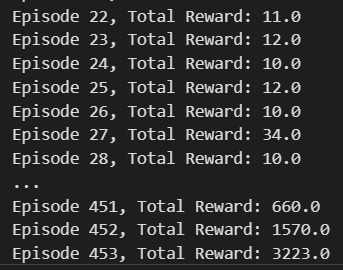

<video controls src="20241001-0547-48.4476389.mp4" title="Title"></video>